In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

In [5]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

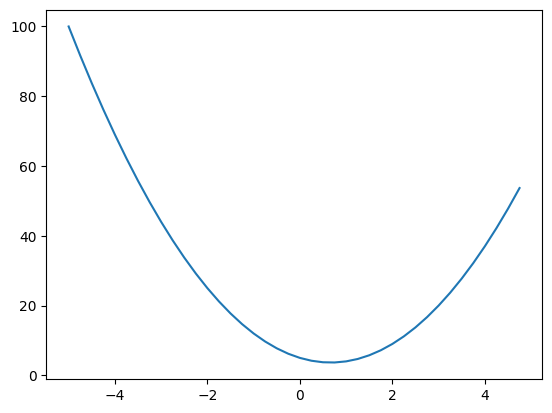

In [6]:
ys = f(xs)
plt.plot(xs, ys)

In [7]:
# what is the derivative of f(x)?
# not a symbolic approach
# what is the derivative measuring?
# slope after adding a little bit (h)
h = 0.0000000001
x = 2/3
(f(x+h) - f(x))/h

0.0

In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
# derivative of d with respect to a, b, and c
h = 0.00001

a = 2.0
b = -3.0
c = 10.0

# d1 = a*b + c
# a += h
# d2 = a*b + c

# print(f'{d1=}')
# print(f'{d2=}')
# print(f'slope={(d2-d1)/h}')


# d1 = a*b + c
# b += h
# d2 = a*b + c

# print(f'{d1=}')
# print(f'{d2=}')
# print(f'slope={(d2-d1)/h}')


d1 = a*b + c
c += h
d2 = a*b + c

print(f'{d1=}')
print(f'{d2=}')
print(f'slope={(d2-d1)/h}')

d1=4.0
d2=4.00001
slope=0.9999999999621422


In [112]:
# lets build some data structures
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        out =  Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):

        # topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [11]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [12]:
from graphviz import Digraph

def trace(root):
    # build a set of all notes & edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right
    
    nodes, edges = trace(root)

    # for any value in the graph create a rectangular 'record' node for it
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and conect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

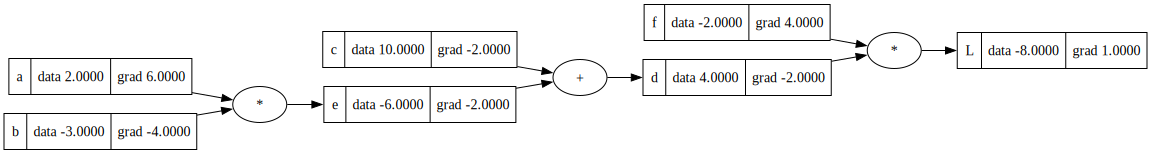

In [33]:
# visualize forward pass
draw_dot(L)

- backprop - walk back the graph and calculate the gradient along the path
- compute derivative of node with respect to L
- derivative of output with respect to its leaf nodes

L = d * f

- dL/dd = f
- dL/df = d

(f(x+h) - f(x))/h

((d+h)*f - d*f) / h
(d*f + h*f - d*f) / h
(h*f)/h
f

- dL / dc (want)
- dd / dc (local)

d = c + e

(f(x+h) - f(x)) / h

((c+h + e) - (c+e))/h
(c + h + e - c - e)/h
h/h
1

- chain rule
dz/dx = dz/dy * dy/dx

WANT:
dL / dc

KNOW:
dL / dd
dd / dc

CHAIN RULE:
dL / dc = dL / dd * dd / dc = f * 1.0

Addition just routes derivative


CHAIN RULE (AGAIN):

dL / de = -2.0

dL / da = (dL / de) * (de / da) = -2.0 * b = -2.0 * -3.0 = 6

In [ ]:
# manual backpropogation
# local derivatives AND derivative from prior step
#   with those 2 pieces of information can apply the
#   chain rule and easily get the derivative with respect to L
#   of a node earlier in the chain
# recursive application of the chain rule through computation graph
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0 # route d.grad because +
e.grad = -2.0 # route d.grad because +
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [ ]:
# nudge in direction of gradient
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# forward pass
e = a * b
d = e + c
L = d * f

# ultimately one step in optimization
# because we understand the gradient it helps us to know how to
#   nudge our values
print(L.data)

-7.286496


In [ ]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data


    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

lol()

-4.000000000008441


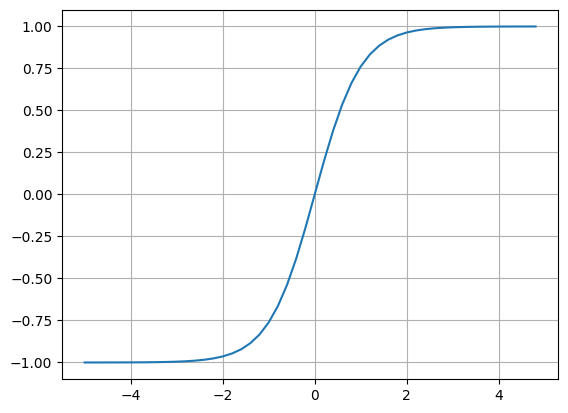

In [ ]:
# backpropogate through a neuron

# tanh squashes data - activation function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [113]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n  = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

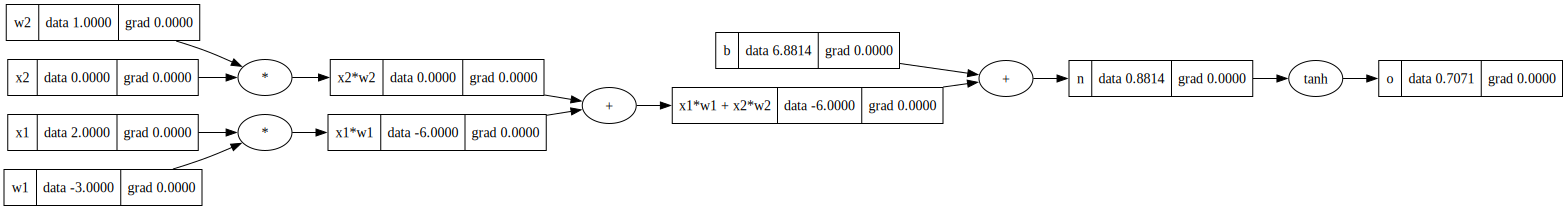

In [114]:
draw_dot(o)

In [110]:
o.backward()

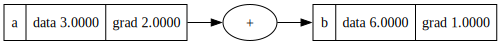

In [115]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [105]:
o.grad = 1.0

# topological sort

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

In [ ]:
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [ ]:
o.grad = 1.0 # base case

In [ ]:
o._backward()

In [92]:
n._backward()

In [94]:
b._backward()

In [95]:
x1w1x2w2._backward()

In [97]:
x2w2._backward()
x1w1._backward()

In [ ]:
# o = tanh(n)
# do / dn = 1 - tanh(n)**2 = 1 - o**2
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

In [80]:
o.data

0.7071067811865476